<a href="https://colab.research.google.com/github/ecandes/stat318/blob/master/Swendsen_Wang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling from the Ising model via the Swendsen-Wang algorithm

We wish to sample from the Ising model 

$$
\pi(x) = \frac{1}{Z} \exp(-\beta E(x)) \qquad E(x) = - \sum_{v \sim v'} x_v x_{v'} 
$$

defined on a graph $G$, where $v \sim v'$ means that the nodes are adjacent. In the energy functional above, each edge is coounted only once.  With this formulation, the critical value of $\beta$ is 

$$
\beta_c = \frac{\log(1+\sqrt{2})}{2} \approx 0.4407
$$

The corresponding critical temperature is 

$$
T_c = \frac{2}{\log(1+\sqrt{2})} \approx 2.2691
$$




In [1]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

plt.rcParams["figure.figsize"] = (4,4)
Tc = 2/np.log(1+np.sqrt(2))

We consider the Swendsen Wang algorithm to do this. We augment the data with bond variables and perform the following update:

- (1) Conditional on a spin configuration $x$, sample bond variables as follows: for each edge $e = (v,v')$, sample a bond variable $b_e$ with 

$$
b_e = \begin{cases} 1 & \text{wp. } 1-e^{-2\beta} \\
0 & \text{wp. } e^{-2\beta}
\end{cases} \qquad \text{if } x_v = x_{v'}
$$

and 

$$
b_e = 0 \qquad \text{if } x_v \neq x_{v'}. 
$$

- (2) Conditional on a bond configurations, update spins by sampling uniformly on all possible configurations; That is, assign i.i.d. $\pm 1$ variables to each cluster. 

We work with the square lattice for our graph $G$ represented below. 

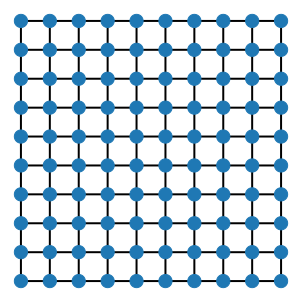

In [72]:
plt.rcParams["figure.figsize"] = (4,4)
L = 10
G = nx.grid_2d_graph(L,L)
pos = dict(zip(G.nodes.keys(),G.nodes.keys()))
options = {'node_size': 175, 'alpha' : 1, 'width' : 2}
nx.draw(G,pos,**options)

Consider a subgraph obtained by removing edges, this will create disconnected components as shown below.

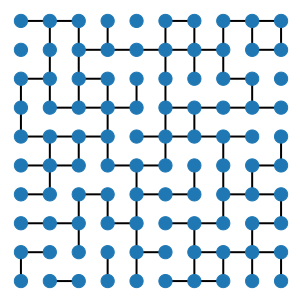

In [73]:
# Remove a fraction of the edges at random
nedges = G.number_of_edges()
U = np.random.rand(nedges) > 0.6
ebunch = [e for e,u in zip(G.edges,U) if u]
G.remove_edges_from(ebunch)
nx.draw(G,pos,**options)

Visualize clusters



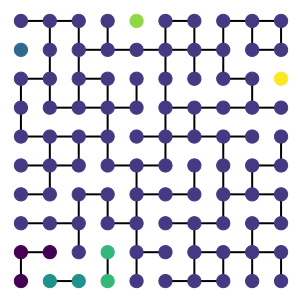

In [74]:
colors = dict.fromkeys(G.nodes())
val = 0
for c in nx.connected_components(G):
  for v in c:
     colors[v] = val
  val +=1

plt.rcParams["figure.figsize"] = (4,4)
nx.draw(G, pos, node_color = list(colors.values()),**options)

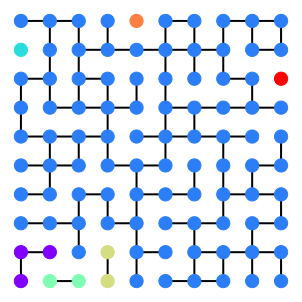

In [75]:
# Different color scheme
nx.draw(G, pos, node_color = list(colors.values()), cmap = plt.cm.get_cmap('rainbow'),**options)

In [145]:
class IsingModel:

    def __init__(self, G, X=None):
        self.G = G                   # Underlying graph
        self.n = G.number_of_nodes()  # Number of nodes
        self.nodes = list(G.nodes.keys())  # List of nodes
        if X is None:
            X = np.ones(self.n).astype(int)
        self.X = dict(zip(self.nodes, X))
        # Useful for plotting
        self.pos = dict(zip(self.nodes, self.nodes))

    def randomBit(self,p):
       return np.random.binomial(1, p, size=1)[0]

    def updateBonds(self,beta,edges=None,method='Swendsen-Wang'):
        ebonds = []
        edges = self.G.edges if method == 'Swendsen-Wang' else edges
        for e in edges:
            if (self.X[e[0]] == self.X[e[1]] and self.randomBit(1-np.exp(-2*beta)) == 1):
                ebonds.append(e) 
        return ebonds 

    def updateSpins_SwendsenWang(self,beta):
        ebonds = self.updateBonds(beta, method='Swendsen-Wang')
        G = nx.Graph()
        G.add_nodes_from(self.G)
        G.add_edges_from(ebonds)

        for c in nx.connected_components(G):
            val = 2*self.randomBit(1/2)-1
            for v in c:
                self.X[v] = val
                
    def updateSpins_Wolff(self,beta):
        start = self.nodes[np.random.randint(0, self.n-1)]
        cluster, checked = {start}, {start}
        
        while True:
            outward_edges = {(node, neighbor) for node in cluster for neighbor in nx.all_neighbors(self.G, node) \
                             if neighbor not in cluster and neighbor not in checked}
            new_nodes_to_check = {neighbor for _, neighbor in outward_edges}
            if len(new_nodes_to_check) == 0:
                break
            ebonds = self.updateBonds(beta, outward_edges, method="Wolff")
            new_nodes_to_add = {neighbor for _, neighbor in ebonds}            
            cluster = cluster | new_nodes_to_add
            checked = checked | new_nodes_to_check
        
        for v in cluster:
            self.X[v] *= -1        

    def sum(self):
        return np.array(list(self.X.values())).sum()

    def mean(self):
        return np.array(list(self.X.values())).mean()

    def drawConfig(self, **options):
        plt.rcParams["figure.figsize"] = (4,4)
        up = [key for key in self.X.keys() if self.X[key] == 1]
        down = [key for key in self.X.keys() if self.X[key] == -1]
        nx.draw(self.G, self.pos, nodelist=up,   node_color="b", **options)
        nx.draw(self.G, self.pos, nodelist=down, node_color="r", **options)
        plt.title('Ising model configuration')
        plt.show()

    def sample(self, T, beta =1, X0=None, method='Swendsen-Wang'):
        if not X0 is None:
            self.X = X0
        for t in range(T):
            if method == 'Swendsen-Wang':
                self.updateSpins_SwendsenWang(beta)
            else:
                self.updateSpins_Wolff(beta)

## Magnetization

We are interested in the distribution of the magnetization $M$ defined as 

$$
M =  f(x) = \sum_v x_v.
$$

We generate a number of samples by running the chain and getting a realization every $T = 100$ time steps. 

In [129]:
def empiricalMagnetization(beta=1,T=100,nsamples=500,method='Swendsen-Wang'):
  chain = IsingModel(nx.grid_2d_graph(L,L))
  magnetization = np.zeros(nsamples)
  for b in range(nsamples):
    chain.sample(T,beta,method=method)
    magnetization[b] = chain.sum()
  
  plt.rcParams["figure.figsize"] = (6,6)
  plt.hist(magnetization)
  plt.title('Magnetization')
  plt.show()
  return magnetization

Let us check a sample after 100 iterations at 

$$
\text{Temperature} = 0.9 T_c
$$

near the critical temperature (a bit below).

### Swendsen-Wang algorithm

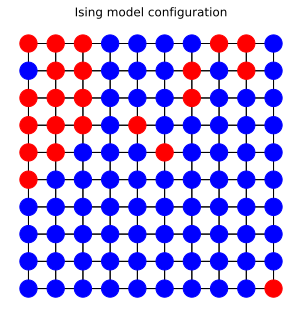

Magnetization at T = 100: 56
CPU times: user 591 ms, sys: 63.5 ms, total: 654 ms
Wall time: 2.01 s


In [146]:
%%time 
Temp = 0.9*Tc
beta = 1/Temp
T = 100
L = 10
method = 'Swendsen-Wang'

chain = IsingModel(nx.grid_2d_graph(L,L))
chain.sample(T,beta,method=method)
chain.drawConfig()
print('Magnetization at T = {}: {}'.format(T,chain.sum()))

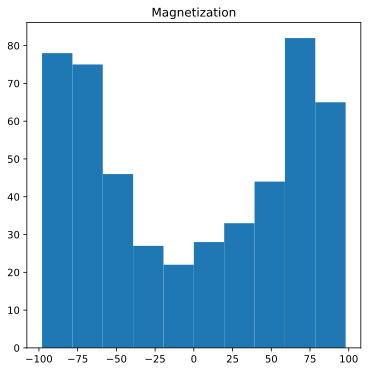

CPU times: user 1min 53s, sys: 1.71 s, total: 1min 55s
Wall time: 5min 39s


In [147]:
%%time
magnetization = empiricalMagnetization(beta=beta, method=method)

### Wolff algorithm

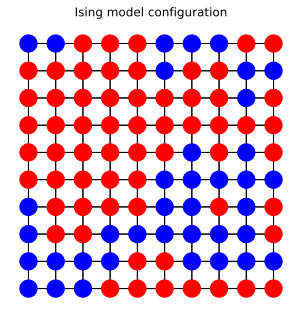

Magnetization at T = 100: -24
CPU times: user 375 ms, sys: 18.2 ms, total: 394 ms
Wall time: 1.61 s


In [148]:
%%time 
Temp = 0.9*Tc
beta = 1/Temp
T = 100
L = 10
method = 'Wolff'

chain = IsingModel(nx.grid_2d_graph(L,L))
chain.sample(T,beta,method=method)
chain.drawConfig()
print('Magnetization at T = {}: {}'.format(T,chain.sum()))

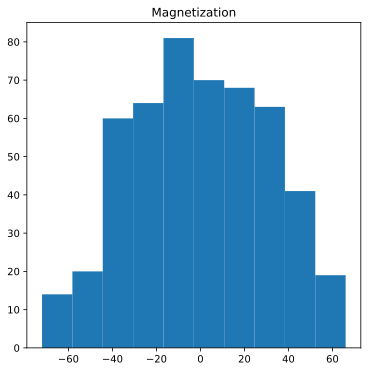

CPU times: user 20.6 s, sys: 360 ms, total: 21 s
Wall time: 1min 13s


In [149]:
%%time
magnetization = empiricalMagnetization(beta=beta, method=method)

## Larger system (64 x 64)

### Swendsen-Wang algorithm

In [150]:
%%time 
Temp = 0.9*Tc
beta = 1/Temp
T = 100
nsamples= 50
method = 'Swendsen-Wang'
L = 64
options = {'node_size': 1, 'alpha' : 1, 'width' : 2}

chain = IsingModel(nx.grid_2d_graph(L,L))
chain.sample(T,beta,method=method)
chain.drawConfig(options=options)
print('Magnetization at T = {}: {}'.format(T,chain.sum()))

Magnetization at T = 100: -3444
CPU times: user 16.9 s, sys: 484 ms, total: 17.4 s
Wall time: 43.9 s


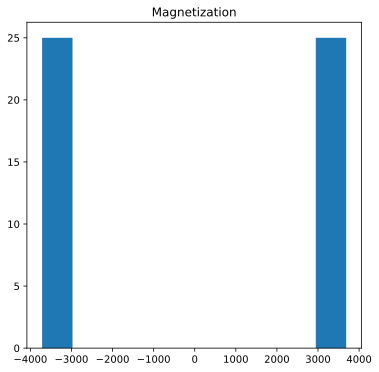

CPU times: user 8min 1s, sys: 6.21 s, total: 8min 7s
Wall time: 21min 18s


In [151]:
%%time
magnetization = empiricalMagnetization(beta=beta, nsamples=nsamples, method=method)

### Wolff algorithm

In [152]:
%%time 
Temp = 0.9*Tc
beta = 1/Temp
T = 100
nsamples = 50
method = 'Wolff'
L = 64
options = {'node_size': 5, 'alpha' : 1, 'width' : 2}

chain = IsingModel(nx.grid_2d_graph(L,L))
chain.sample(T,beta,method=method)
chain.drawConfig(options=options)
print('Magnetization at T = {}: {}'.format(T,chain.sum()))

Magnetization at T = 100: 162
CPU times: user 7.72 s, sys: 156 ms, total: 7.87 s
Wall time: 21.5 s


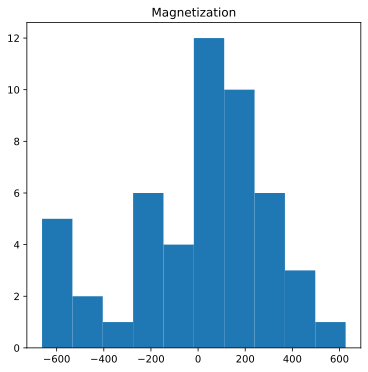

CPU times: user 5.18 s, sys: 78.4 ms, total: 5.26 s
Wall time: 17.9 s


In [153]:
%%time
magnetization = empiricalMagnetization(beta=beta, nsamples=nsamples, method=method)

## Interpretation

A bit below the critical temperature, we see that the Wolff algorithm runs faster than the Swendsen-Wang algorithm if both algorithms updates the spins the same number of trials, but the Wolff algorithm may take more iterations to converge.